In [22]:
from imports import *

In [27]:
def main_delta(base_folder,local_path,**kwargs):
    length_compute_fr = kwargs['length_compute_fr']


    bk.load.current_session_linux(base_folder,local_path)
    
    neurons, metadata = bk.load.spikes()
    metadata = bk.load.metadata_with_side(metadata)

    states = bk.load.states(True)
    extended_sleep = bk.compute.extended(states)
    if len(extended_sleep) == 0: return None
    # else: return metadata
    deltas = {}
    for state in ['NREM','REM']:
        deltas[state] = []
        for s, e in extended_sleep.iloc:
            current_sleep = nts.IntervalSet(s, e)
            state_intervals = states[state].intersect(current_sleep)
            act = bk.compute.binSpikes(neurons,1,as_Tsd = True).restrict(state_intervals)
            act = bk.compute.nts_zscore(act)
            fr_beg = np.nansum(act.iloc[0:length_compute_fr].values,0)/length_compute_fr
            print(fr_beg)
            fr_end = np.nansum(act.iloc[-length_compute_fr:-1].values,0)/length_compute_fr
            deltas[state].append(fr_end-fr_beg)

        
    gamma = bk.load.analysis('Gamma/gamma_intervals')
    gamma_participation = {}
    for state in ['NREM','REM']:
        gamma_participation[state] = []
        for n,m in zip(neurons,metadata.iloc):
            if m.Region == 'Hpc':
                g = gamma[state]['Hpc']['intervals']
            elif m.Region == 'BLA':
                g = gamma[state][m.Side]['intervals']
            else:
                gamma_participation[state].append(np.nan)
                continue
        
            n = n.restrict(states[state])
            gamma_participation[state].append(np.sum(g.in_interval(n)>0)/len(n))
    
        # print(len(gamma_participation[state]))
    df = pd.DataFrame({'delta_NREM':np.nanmean(deltas['NREM'],0),
                       'delta_REM':np.nanmean(deltas['REM'],0),
                       'gamma_participation_nrem':gamma_participation['NREM'],
                       'gamma_participation_rem':gamma_participation['REM'],

                    }
                    )
    df = pd.concat((metadata,df),1)
    return df

In [28]:
kwargs = {}
kwargs['length_compute_fr'] = 30
bk.load.current_session_linux()
batch, metadata = bk.load.batch(main_delta, **kwargs,verbose=False)
# df = main_delta(bk.load.base,'Rat09/Rat09-20140329',**kwargs)
# df = main_delta(bk.load.base,'Rat08/Rat08-20130713',**kwargs)
# df

100%|██████████| 61/61 [01:51<00:00,  1.82s/it]

['Rat08-20130720', 'Rat08-20130722', 'Rat09-20140408', 'Rat09-20140409']
Batch finished in 111.03549361228943
Some session were not processed correctly
['Rat08-20130720', 'Rat08-20130722', 'Rat09-20140408', 'Rat09-20140409']
6.557377049180328 %


In [29]:
df = pd.concat(batch)
pyr = df[(df.Region == 'BLA') & (df.Type == 'Pyr')]
pyr

Rat Day Shank Id Region Type   Side  delta_NREM  delta_REM  \
Rat08-20130708 39   8   1     7  2    BLA  Pyr   left    0.096495   0.044055   
               40   8   1     7  3    BLA  Pyr   left    0.044363   1.288756   
               41   8   1     7  4    BLA  Pyr   left    0.161817   0.058881   
               42   8   1     7  5    BLA  Pyr   left   -0.589658   0.327136   
               43   8   1     7  6    BLA  Pyr   left    0.199758  -0.079030   
...                ..  ..   ... ..    ...  ...    ...         ...        ...   
Rat11-20150331 27  11  19     6  3    BLA  Pyr  right   -0.535235   0.188477   
               28  11  19     6  4    BLA  Pyr  right   -0.150509  -0.001109   
               29  11  19     7  2    BLA  Pyr  right    0.399580   0.283914   
               30  11  19     7  3    BLA  Pyr  right    0.118264  -0.058712   
               31  11  19     7  4    BLA  Pyr  right    0.070500  -0.033589   

                   gamma_participation_nrem  gamma_participation_rem  
Rat08-20130708 39                  0.039775                 0.021531  
               40                  0.037467                 0.036215  
               41                  0.032182                 0.028926  
               42                  0.039144                 0.038057  
               43                  0.034182                 0.026362  
...                                     ...                      ...  
Rat11-20150331 27                  0.022042                 0.020408  
               28                  0.035503                 0.027115  
               29                  0.027752                 0.021566  
               30                  0.025051                 0.014577  
               31                  0.036680                 0.053061  

[1208 rows x 11 columns]

In [5]:
fr_states

NameError: name 'fr_states' is not defined

In [6]:
def fr_run(base_folder,local_path):
    bk.load.current_session_linux(base_folder,local_path)
    run = bk.load.run_intervals()
    neurons, metadata = bk.load.spikes()
    fr_run = []
    for n in neurons:
        fr_run.append(bk.compute.fr(n,run))
    df = pd.DataFrame(fr_run,columns=['RUN'])
    df = pd.concat((metadata,df),1)

    return df

In [7]:
b,m = bk.load.batch(fr_run)

100%|██████████| 61/61 [01:20<00:00,  1.32s/it]

['Rat08-20130722', 'Rat09-20140408', 'Rat09-20140409']
Batch finished in 80.31156396865845
Some session were not processed correctly
['Rat08-20130722', 'Rat09-20140408', 'Rat09-20140409']
4.918032786885246 %


In [8]:
fr_run = pd.concat(b)

In [11]:
fr_run

Rat Day Shank  Id Region Type       RUN
Rat08-20130708 0    8   1     4   2    Hpc  Pyr  0.598341
               1    8   1     4   3    Hpc  Pyr  0.849601
               2    8   1     4   4    Hpc  Int  0.208674
               3    8   1     4   5    Hpc  Pyr  0.723971
               4    8   1     4   6    Hpc  Pyr  0.410960
...                ..  ..   ...  ..    ...  ...       ...
Rat11-20150403 48  11  22    12  11    Pir  Pyr  2.817554
               49  11  22    12  12    Pir  Pyr  1.466925
               50  11  22    12  13    Pir  Pyr  0.148014
               51  11  22    12  14    Pir  Pyr  0.251095
               52  11  22    13   2    Pir  Pyr  2.862486

[7123 rows x 7 columns]

In [115]:
bk.load.current_session_linux(byrat = 11, byday=22)

Rat : 11 on day : 22
Working with session Rat11-20150403 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat11/Rat11-20150403


True

/tmp/ipykernel_1375546/756739595.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.merge(fr_states,fr_run,how='right')


,Rat,Day,Shank,Id,Region,Type,wake,drowsy,WAKE_HOMECAGE,NREM,REM,SLEEP,RUN
0,8.0,1.0,4.0,2.0,Hpc,Pyr,0.553571,0.371076,0.604555,0.873333,1.995636,1.038426,0.598341
1,8.0,1.0,4.0,3.0,Hpc,Pyr,0.689208,0.933857,0.749210,0.725484,0.658978,0.715701,0.849601
2,8.0,1.0,4.0,4.0,Hpc,Int,0.265140,0.178251,0.334955,0.398710,0.304863,0.384905,0.208674
3,8.0,1.0,4.0,5.0,Hpc,Pyr,1.005745,1.386771,1.278268,1.118065,0.517456,1.029714,0.723971
4,8.0,1.0,4.0,6.0,Hpc,Pyr,0.488509,0.815022,0.586920,0.384409,0.314214,0.374083,0.410960
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7118,11,22,12,11,Pir,Pyr,NaN,NaN,NaN,NaN,NaN,NaN,2.817554
7119,11,22,12,12,Pir,Pyr,NaN,NaN,NaN,NaN,NaN,NaN,1.466925
7120,11,22,12,13,Pir,Pyr,NaN,NaN,NaN,NaN,NaN,NaN,0.148014
7121,11,22,12,14,Pir,Pyr,NaN,NaN,NaN,NaN,NaN,NaN,0.251095


In [110]:
fr_run

Rat Day Shank  Id Region Type       RUN
Rat08-20130708 0    8   1     4   2    Hpc  Pyr  0.598341
               1    8   1     4   3    Hpc  Pyr  0.849601
               2    8   1     4   4    Hpc  Int  0.208674
               3    8   1     4   5    Hpc  Pyr  0.723971
               4    8   1     4   6    Hpc  Pyr  0.410960
...                ..  ..   ...  ..    ...  ...       ...
Rat11-20150403 48  11  22    12  11    Pir  Pyr  2.817554
               49  11  22    12  12    Pir  Pyr  1.466925
               50  11  22    12  13    Pir  Pyr  0.148014
               51  11  22    12  14    Pir  Pyr  0.251095
               52  11  22    13   2    Pir  Pyr  2.862486

[7123 rows x 7 columns]

In [107]:
fr_states

,Rat,Day,Shank,Id,Region,Type,wake,drowsy,WAKE_HOMECAGE,NREM,REM,SLEEP
0,8,1,4,2,Hpc,Pyr,0.553571,0.371076,0.604555,0.873333,1.995636,1.038426
1,8,1,4,3,Hpc,Pyr,0.689208,0.933857,0.749210,0.725484,0.658978,0.715701
2,8,1,4,4,Hpc,Int,0.265140,0.178251,0.334955,0.398710,0.304863,0.384905
3,8,1,4,5,Hpc,Pyr,1.005745,1.386771,1.278268,1.118065,0.517456,1.029714
4,8,1,4,6,Hpc,Pyr,0.488509,0.815022,0.586920,0.384409,0.314214,0.374083
...,...,...,...,...,...,...,...,...,...,...,...,...
6700,11,20,18,14,Hpc,Pyr,2.695594,4.007692,2.887911,1.320266,0.655777,1.195107
6701,11,20,18,15,Hpc,Int,9.263293,8.361538,9.062679,8.589497,5.254980,7.961429
6702,11,20,20,2,Hpc,Pyr,3.335514,1.761538,3.267870,2.153476,7.678884,3.194207
6703,11,20,20,3,Hpc,Pyr,0.302867,0.269231,0.286652,2.248706,2.733865,2.340087


In [13]:
fr_states = pd.read_csv(f'{bk.load.base}/All-Rats/States/fr_states.csv')


In [20]:
fr_states = pd.read_csv(f'{bk.load.base}/All-Rats/States/fr_states.csv')
fr_states = pd.merge(fr_states,fr_run,how='inner')
fr_states.to_csv(f'{bk.load.base}/All-Rats/States/fr_states.csv',index=False)

In [17]:
fr_states

,Rat,Day,Shank,Id,Region,Type,wake,drowsy,WAKE_HOMECAGE,NREM,REM,SLEEP,RUN
0,8,1,4,2,Hpc,Pyr,0.553571,0.371076,0.604555,0.873333,1.995636,1.038426,0.598341
1,8,1,4,3,Hpc,Pyr,0.689208,0.933857,0.749210,0.725484,0.658978,0.715701,0.849601
2,8,1,4,4,Hpc,Int,0.265140,0.178251,0.334955,0.398710,0.304863,0.384905,0.208674
3,8,1,4,5,Hpc,Pyr,1.005745,1.386771,1.278268,1.118065,0.517456,1.029714,0.723971
4,8,1,4,6,Hpc,Pyr,0.488509,0.815022,0.586920,0.384409,0.314214,0.374083,0.410960
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6936,11,22,12,11,Pir,Pyr,0.760866,0.608696,0.580511,1.071624,1.196078,1.093201,2.817554
6937,11,22,12,12,Pir,Pyr,1.054621,1.065217,1.017765,1.200822,1.983660,1.336544,1.466925
6938,11,22,12,13,Pir,Pyr,0.112906,0.369565,0.110477,0.282042,0.411765,0.304533,0.148014
6939,11,22,12,14,Pir,Pyr,0.302581,0.152174,0.318684,0.312200,0.553922,0.354108,0.251095


NREM -0.1096991965037406 0.00013413488917378752
REM -0.03200993567206945 0.266474240831397
WAKE_HOMECAGE -0.2734033135177135 3.903814007964311e-22
RUN -0.2844419999418882 1.3862548724614618e-23
NREM -0.12336781384645645 0.10185457032145954
REM -0.059899729506906536 0.4283727808221568
WAKE_HOMECAGE -0.08395591884359774 0.26656418407160626
RUN -0.09732753722908251 0.1974863358816079


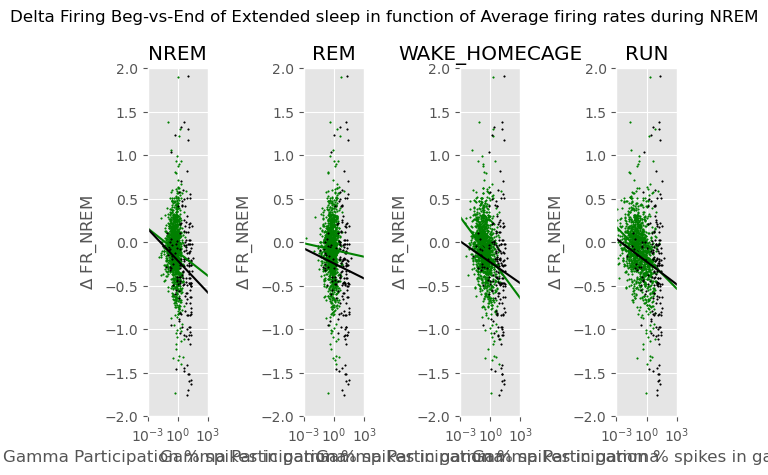

In [10]:
df = pd.concat(batch)
fr_states = pd.read_csv(f'{bk.load.base}/All-Rats/States/fr_states.csv')
fr_states = pd.merge(fr_states,fr_run,how='inner')
theta = pd.read_csv(f'{bk.load.base}/All-Rats/Frequency_Modulation/theta.csv')
df = pd.merge(fr_states, df)
# df = pd.merge(theta, df)


fig,ax = plt.subplots(1,4)


for color,types in zip(['green','black'],['Pyr','Int']):
    df_type = df[(df.Region == 'BLA') & (df.Type == types)]
    df_type = df_type.dropna()
    for i,state in enumerate(['NREM','REM','WAKE_HOMECAGE','RUN']):

        zeros = df_type[state] == 0
        x_values = df_type[state][~zeros]
        y_values = df_type.delta[~zeros]
        reg = scipy.stats.linregress(np.log10(x_values),y_values)
        print(state,reg.rvalue,reg.pvalue)
        x = np.linspace(-3, 3)
        y = x*reg.slope+reg.intercept


        ax[i].scatter(x_values,y_values, s=1,c = color)
        ax[i].plot(10**x, y,c = color)
        ax[i].semilogx()
        ax[i].set_ylim(-2,2)
        ax[i].set_xlim(0.001,1000)
        ax[i].set_xlabel('Gamma Participation % spikes in gamma ')
        ax[i].set_ylabel(f'$\Delta$ FR_NREM')
        ax[i].set_title(state)
        plt.suptitle('Delta Firing Beg-vs-End of Extended sleep in function of Average firing rates during NREM')
    plt.tight_layout()

In [52]:
np.sum(df[(df.Region == 'BLA') & (df.Type == 'Int')].delta <0) / len((df[(df.Region == 'BLA') & (df.Type == 'Int')])) * 100

75.70621468926554

1208

In [6]:
pyr = df[(df.Region == 'BLA') & (df.Type == 'Pyr')]

In [7]:
pyr[np.isnan(pyr.delta)]

,Rat,Day,Shank,Id,Region,Type,FR_Rem,MRL,Kappa,pValue,...,wake,drowsy,WAKE_HOMECAGE,NREM,REM,SLEEP,Side,delta,gamma_participation_nrem,gamma_participation_rem
